# Deep Learning Exam - Emotion Detection
## Student: Giuseppe Tanzi

The task consists in creating a Emotion Detection model, able to recognise the emotion expressed in a given text/sentence. 

Thus, you have a NLP task and for this reason the steps are the following:
 - Preprocessing of the dataset;
 - Create a model able to classify the text;
 - Train the model;
 - Evaluate the model.

*Import libraries and utility functions*

In [1]:
!pip install tensorflow_addons
!pip install keras-self-attention
!pip install keras-tcn
!pip install contractions
!pip install demoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18912 sha256=e31cb620994621693d2f0ef485a9d8e891857ede799deabf5189c237ee6d74ec
  Stored in directory: /root/.cache/pip/wheels/95/b1/a8/5ee00cc137940b2f6fa198212e8f45d813d0e0d9c3a04035a3
Successfully built keras-self-attention
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 6.6 MB/s 
     |████████████████████████████████| 287 kB 33.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |█

In [2]:
import pandas as pd
import numpy as np
import re
import os
import pathlib
import nltk
import contractions
import demoji
import matplotlib.pyplot as plt

from nltk import TweetTokenizer

import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import Model
from keras.layers import Input, Dense, Dropout, Embedding
from keras.layers import Bidirectional, LSTM, Concatenate, concatenate
from keras.layers import Conv1D, SpatialDropout1D, GlobalMaxPool1D
from keras.layers import GlobalMaxPooling1D, MaxPool1D, Attention, GlobalAveragePooling1D
from keras_self_attention import SeqSelfAttention
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model

from tcn import TCN, tcn_full_summary

from collections import Counter
from collections import defaultdict

from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, f1_score

In [3]:
def display_history(history):
    loss_training = history.history['loss']
    f1_training = history.history['f1_score']

    loss_val = history.history['val_loss']
    f1_val = history.history['val_f1_score']

    # Visualize the behavior of the loss
    plt.plot(loss_training)
    plt.plot(loss_val)
    plt.grid()
    plt.title('Loss during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

    # and of the f1-score
    plt.plot(f1_training)
    plt.plot(f1_val)
    plt.grid()
    plt.title('F1 score during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

*Preprocessing for Gloove imported from https://www.kaggle.com/code/amackcrane/python-version-of-glove-twitter-preprocess-script/script*

In [4]:
FLAGS = re.MULTILINE | re.DOTALL

def hashtag(text):
    text = text.group()
    hashtag_body = text[1:]
    if hashtag_body.isupper():
        result = "<hashtag> {} <allcaps>".format(hashtag_body.lower())
    else:
        result = " ".join(["<hashtag>"] + re.split(r"(?=[A-Z])", hashtag_body, flags=FLAGS))
    return result

def allcaps(text):
    text = text.group()
    return text.lower() + " <allcaps> " # amackcrane added trailing space


def gloove_cleaner(text):
    # Different regex parts for smiley faces
    eyes = r"[8:=;]"
    nose = r"['`\-]?"

    # function so code less repetitive
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)

    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>")
    text = re_sub(r"@\w+", "<user>")
    text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "<smile>")
    text = re_sub(r"{}{}p+".format(eyes, nose), "<lolface>")
    text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "<sadface>")
    text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "<neutralface>")
    text = re_sub(r"/"," / ")
    text = re_sub(r"<3","<heart>")
    text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "<number>")
    text = re_sub(r"#\w+", hashtag)  # amackcrane edit
    text = re_sub(r"([!?.]){2,}", r"\1 <repeat>")
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong>")

    # amackcrane additions
    text = re_sub(r"([a-zA-Z<>()])([?!.:;,])", r"\1 \2")
    text = re_sub(r"\(([a-zA-Z<>]+)\)", r"( \1 )")
    text = re_sub(r"  ", r" ")
    text = re_sub(r" ([A-Z]){2,} ", allcaps)
    
    return text.lower()

In [12]:
def cleaner(sentence):

  # EXPANDING THE CONTRACTED FORMS
  expanded_forms = []   
  for word in sentence.split():
    expanded_forms.append(contractions.fix(word))  
  sentence = ' '.join(expanded_forms)

  # CONVERT EMOJI TO TEXT
  sentence = demoji.replace(sentence, '')

  # SAXON GENITIVE
  sentence = re.sub("'s", '', sentence)

  # GLOOVE CLEANING
  sentence = gloove_cleaner(sentence)

  # TOKENIZER OF TWITTER
  tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
  sentence = tknzr.tokenize(sentence)

  return sentence

In [6]:
def prepare_targets(train, test, val):

	ohe = OneHotEncoder(sparse = False, dtype='uint8')
 
	ohe.fit(train)
	train_enc = ohe.transform(train)
	test_enc = ohe.transform(test)
	val_enc = ohe.transform(val)
 
	return train_enc, test_enc, val_enc

*Load dataset*

In [8]:
!unzip data.zip

Archive:  data.zip
  inflating: test_ekmann.csv         
  inflating: train_ekmann.csv        
  inflating: val_ekmann.csv          


The dataset is composed of 58k texts labelled manually to assign them an emotion:
- Anger
- Digust
- Fear
- Joy
- Sadness
- Surprise
- Neutral

The dataset is unbalanced, but techniques of data augmentation or random oversampling didn't obtain good results. 

For this reason I decided not to adapt any strategy to make the dataset more balanced.

In [13]:
train = pd.read_csv('train_ekmann.csv')
test = pd.read_csv('test_ekmann.csv')
val = pd.read_csv('val_ekmann.csv')

## Pre-processing 

Some preprocessing step have been performed:
- Expansion of the contracted forms;
- Conversion of emoji to text;
- Removal of the Saxon genitive;
- Specific preprocessing for Gloove;
- Specific tokenization for twitter text.

In [14]:
for df in [train, test, val]:
  df['Text'] = df.apply(lambda row: cleaner(row['Text']), axis=1)

*Counting the number of words*

In [15]:
train_c = Counter()
train['Text'].apply(train_c.update)

vocab_size = len(train_c)

print("Number of words in vocabulary: ", vocab_size)

Number of words in vocabulary:  26246


In [16]:
x_train = train[['Text']]
y_train = train[['Emotion']]
x_test = test[['Text']]
y_test = test[['Emotion']]
x_val = val[['Text']]
y_val = val[['Emotion']]

- The sentences have been transformed into sequences of values in order to be able to give them in input to the model

In [17]:
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

max_len = 200

train_sentences = x_train['Text'].to_numpy()
test_sentences = x_test['Text'].to_numpy()
val_sentences = x_val['Text'].to_numpy()

tokenizer = Tokenizer(oov_token = oov_tok, num_words = vocab_size)
tokenizer.fit_on_texts(train_sentences)

training_sequences = tokenizer.texts_to_sequences(train_sentences)
testing_sequences = tokenizer.texts_to_sequences(test_sentences)
validation_sequences = tokenizer.texts_to_sequences(val_sentences)

x_train_vec = pad_sequences(training_sequences, maxlen=max_len, padding = padding_type, truncating = trunc_type)
x_val_vec = pad_sequences(validation_sequences, maxlen=max_len, padding = padding_type, truncating = trunc_type)
x_test_vec = pad_sequences(testing_sequences, maxlen=max_len, padding = padding_type, truncating = trunc_type)

*One-hot encoding*

In [18]:
y_train_enc, y_test_enc, y_val_enc = prepare_targets(y_train, y_test, y_val)

## Word Embedding

I used **Gloove** for twitter text with 200 as dimension of the vectors.

**GloVe** is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

In [19]:
!wget https://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip -q glove.twitter.27B.zip

--2022-06-30 08:27:46--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2022-06-30 08:27:46--  https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [application/zip]
Saving to: ‘glove.twitter.27B.zip’

glove.twitter.27B.z 100%[===================>]   1.42G  5.04MB/s    in 4m 50s  

2022-06-30 08:32:36 (5.00 MB/s) - ‘glove.twitter.27B.zip’ saved [1520408563/1520408563]



In [20]:
path_to_glove_file = os.path.join(
    os.path.expanduser("~"), '/content/glove.twitter.27B.200d.txt')

embeddings_index = {}
f = open(path_to_glove_file)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


I created the embedding matrix, starting from the Gloove vectors, necessary for the weight of the embedding layer.

In [21]:
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, max_len))

for word, index in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# First Model 1

Searching around I found an interesting paper$^{1}$ on Emotion Detection task, so I tried to implement the network used to the comparison of word-embedding in the paper.

The model applied in this study use the long-short term memory networks (LSTM) in their bidirectional variation and the convolutional neural netowrks (CNN) mediated by a max pooling approach. Furthermore they use a self-attention layer to allow the system to capture distant relationships among words with a different weight depending theirs contribute for classification.



In particural the architecture is the following:
- the first layer is an **embedding layer** that has the pre-trained Gloove embedding matrix;
- the second layer is a **Bi-LSTM layer** that considers the intrinsic sequential relationship between the terms of a sentence; 
- the third layer is a **Self-Attention layer** that provides the model ability to weight the vectors of single words of the sentence differently, according to the similarity of the neighboring tokens;
- the fourth layer is a **CNN layer**, ideal for working on data with a shape of grid; the result is a grid more dense and smaller of the previous that captures the hidden relations among cells that fall in the kernel dimension;
- it has been applied a between the output of the **CNN layer** and the output of the previous **Bi-LSTM layer** in order to letting the model to better conceptualize both local and long-term features;
- then there are operations of **max pooling** followed by operations of **global average pooling**;
- finally there are **dense layers** that estimates the probability distribution of each of the emotional classes of the dataset.

I added some regularizer into the self attention layer in order to prevent overfitting

In [22]:
def build_first_model(name):

  inputs = Input((max_len))
  emb = Embedding(input_dim = len(word_index) + 1, 
                  output_dim = max_len,
                  weights = [embedding_matrix],
                  input_length = max_len,
                  trainable = True,
                  name = 'embedding')(inputs)
  l1 = Bidirectional(LSTM(200, return_sequences = True, dropout=0.3, activation='tanh'))(emb)
  l2 = SeqSelfAttention(attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                        kernel_regularizer=keras.regularizers.l2(1e-4),
                        bias_regularizer=keras.regularizers.l1(1e-4),
                        attention_regularizer_weight=1e-4,
                        attention_width=15,
                        name='Attention')(l1)
  l3 = Conv1D(400, 5, activation='relu')(l2)
  l4 = MaxPool1D(2)(l3)
  l5 = Dropout(0.2)(l4)
  concatted = Concatenate(axis=1)([l1, l5])
  l6 = GlobalMaxPool1D()(concatted)
  l7 = Dense(100)(l6)
  l8 = Dropout(0.2)(l7)
  output = Dense(y_train_enc.shape[1], activation = 'softmax')(l8)

  model = Model(inputs = inputs, outputs = output, name = name)

  return model

I used the Adam optimizer and the categorical crossentropy as loss because we have a classification task.


In [76]:
first_model = build_first_model('first_model')
first_model.compile(loss = 'categorical_crossentropy', 
                      optimizer = 'adam', 
                      metrics = tfa.metrics.F1Score(num_classes = y_train_enc.shape[1], average='macro'))
first_model.summary()

Model: "first_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 200, 200)     5249600     ['input_6[0][0]']                
                                                                                                  
 bidirectional_5 (Bidirectional  (None, 200, 400)    641600      ['embedding[0][0]']              
 )                                                                                                
                                                                                                  
 Attention (SeqSelfAttention)   (None, 200, 400)     160001      ['bidirectional_5[0][0]

### Structure

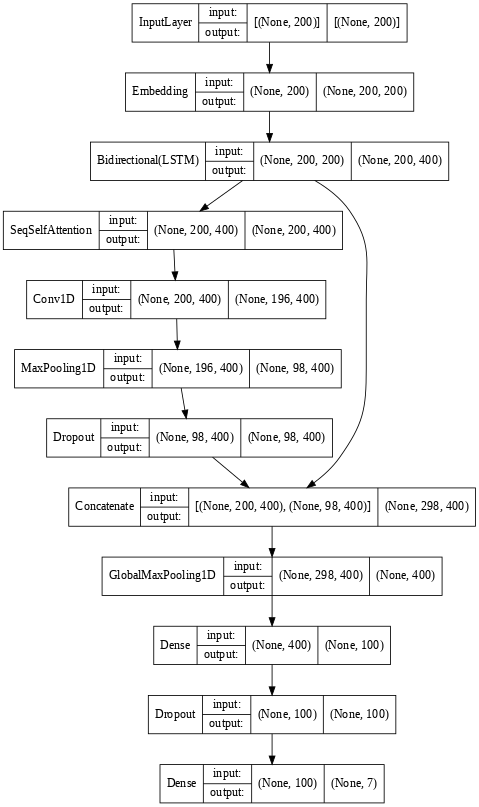

In [52]:
plot_model(first_model, show_shapes=True, show_layer_names=False, dpi=60)

## Fine tuning

I decided to train the entire network for 1 epoch in order to fine tune the pre-trained embedding layer.

In [77]:
ft_mc = ModelCheckpoint('./fine_tuning.h5', 
                      monitor = 'val_loss', 
                      mode = 'min', 
                      verbose = 1, 
                      save_best_only = True)

first_model.fit(x_train_vec, y_train_enc,
                epochs = 1, batch_size = 256,
                validation_data = (x_val_vec,y_val_enc),
                verbose = 1,
                callbacks = ft_mc)

170/170 [==============================] - ETA: 0s - loss: 1.2228 - f1_score: 0.3738
Epoch 1: val_loss improved from inf to 1.00299, saving model to ./fine_tuning.h5
170/170 [==============================] - 63s 246ms/step - loss: 1.2228 - f1_score: 0.3738 - val_loss: 1.0030 - val_f1_score: 0.5379


*Set training of the embedding layer to False*

In [78]:
first_model.layers[1].trainable = False
first_model.compile(loss = 'categorical_crossentropy', 
                      optimizer = 'adam', 
                      metrics = tfa.metrics.F1Score(num_classes = y_train_enc.shape[1], average='macro'))
first_model.summary()

Model: "first_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 200, 200)     5249600     ['input_6[0][0]']                
                                                                                                  
 bidirectional_5 (Bidirectional  (None, 200, 400)    641600      ['embedding[0][0]']              
 )                                                                                                
                                                                                                  
 Attention (SeqSelfAttention)   (None, 200, 400)     160001      ['bidirectional_5[0][0]

*Loading weights fine tuned*

In [79]:
first_model.load_weights('./fine_tuning.h5')

## Training

Two callbacks were used:
- **Early stopping**: callback that stops the training when the model starts to overfit and it restores the best weights based on the value of the *macro f1 score* on the validation set, since you want to maximize it;
- **ModelCheckpoint**: callback that saves the best weights based on the value of the *macro f1 score* on the validation set.

The value of epochs is 20 and the value of batch size is equal to 64.

The values of parameters have been tuned during some experiments.

In [80]:
early1 = EarlyStopping(monitor = "val_f1_score", 
                         mode = "max", 
                         min_delta = 0, 
                         patience=4, 
                         verbose = 2,
                         restore_best_weights = True)

mc1 = ModelCheckpoint('./first_model.h5', 
                      monitor = 'val_f1_score', 
                      mode = 'max', 
                      verbose = 1, 
                      save_best_only = True)

In [81]:
history = first_model.fit(x_train_vec, y_train_enc,
                    epochs = 20, batch_size = 64,
                    validation_data = (x_val_vec,y_val_enc),
                    verbose = 1,
                    callbacks = [mc1, early1])

Epoch 1/20
678/679 [============================>.] - ETA: 0s - loss: 1.0032 - f1_score: 0.5319
Epoch 1: val_f1_score improved from -inf to 0.58142, saving model to ./first_model.h5
679/679 [==============================] - 53s 72ms/step - loss: 1.0032 - f1_score: 0.5319 - val_loss: 0.9459 - val_f1_score: 0.5814
Epoch 2/20
678/679 [============================>.] - ETA: 0s - loss: 0.9345 - f1_score: 0.5626
Epoch 2: val_f1_score did not improve from 0.58142
679/679 [==============================] - 48s 71ms/step - loss: 0.9345 - f1_score: 0.5625 - val_loss: 0.9370 - val_f1_score: 0.5503
Epoch 3/20
678/679 [============================>.] - ETA: 0s - loss: 0.9067 - f1_score: 0.5724
Epoch 3: val_f1_score improved from 0.58142 to 0.58522, saving model to ./first_model.h5
679/679 [==============================] - 48s 71ms/step - loss: 0.9067 - f1_score: 0.5723 - val_loss: 0.9279 - val_f1_score: 0.5852
Epoch 4/20
678/679 [============================>.] - ETA: 0s - loss: 0.8758 - f1_score

## Evaluation 

In [82]:
y_pred = np.argmax(first_model.predict(x_test_vec), axis = 1)
y_true = np.argmax(y_test_enc, axis = 1)

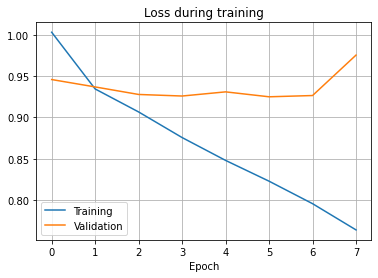

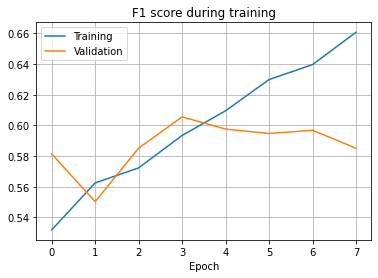

In [84]:
display_history(history)

In [83]:
print(classification_report(y_true, y_pred))
print("F1-score: " + str(f1_score(y_true, y_pred, average = 'macro')))

              precision    recall  f1-score   support

           0       0.49      0.50      0.50       572
           1       0.51      0.53      0.52       116
           2       0.68      0.64      0.66        81
           3       0.75      0.82      0.79      1978
           4       0.65      0.58      0.61      1648
           5       0.69      0.48      0.57       355
           6       0.57      0.64      0.61       677

    accuracy                           0.66      5427
   macro avg       0.62      0.60      0.61      5427
weighted avg       0.66      0.66      0.66      5427

F1-score: 0.6080837323476918


As you can see the model starts to overfit after the 4th epoch, hence the weights of the 4th epoch have been restored.

The model reached a good performance, with a **F1-score** of **0.61**.

# Second model

I used another model as alternative to the first one in order to try to improve the performance.

I found another interesting paper$^{2}$ on Sequence Modelling that proposed a generic temporal convolutional network (TCN) as a dilated-causal version of CNN. It works as a strong alternative to recurent architectures that can handle a long input sequence without suffering from vanishing or exploding gradient problems.

The proposed TCN model is inspired by Christof Henkel$^3$, one of the grandmasters on Kaggle. 

The model consists of:

- Two TCN blocks stacked with the kernel size of 3 and dilation factors of 1, 2, and 4;
- The first TCN block contains 128 filters, and the second block uses 64 filters; the input features will be based on Word Embedding;
- Each block’s result will take the form of a sequence;
- The final sequence is then passed to two different global pooling layers;
- Next, both results are concatenated and passed into a dense layer of 16 neurons, and pass to the output.

In [85]:
def tcn_model(kernel_size = 3, activation='relu', input_dim = None, 
                   output_dim=300, emb_matrix = None, max_length = None):
    
    inp = Input( shape=(max_length,))
    x = Embedding(input_dim=input_dim, 
                  output_dim=max_length,
                  input_length = max_length,
                  weights = [emb_matrix],
                  trainable = False)(inp)
    
    x = SpatialDropout1D(0.1)(x)
    
    x = TCN(128,dilations = [1, 2, 4], return_sequences=True, activation = activation, name = 'tcn1')(x)
    x = TCN(64,dilations = [1, 2, 4], return_sequences=True, activation = activation, name = 'tcn2')(x)
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPool1D()(x)
    
    conc = concatenate([avg_pool, max_pool])
    conc = Dense(16, activation="relu")(conc)
    conc = Dropout(0.1)(conc)
    outp = Dense(y_train_enc.shape[1], activation="softmax")(conc)    

    model = Model(inputs=inp, outputs=outp)

    return model

In [86]:
second_model = tcn_model(input_dim = len(word_index) + 1, 
                         max_length = max_len, 
                         emb_matrix = embedding_matrix)

second_model.compile(loss = 'categorical_crossentropy', 
                      optimizer = 'adam', 
                      metrics = tfa.metrics.F1Score(num_classes = y_train_enc.shape[1], average='macro'))

second_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 200, 200)     5249600     ['input_7[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 200, 200)    0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 tcn1 (TCN)                     (None, 200, 128)     349056      ['spatial_dropout1d[0][0]']  

## Structure

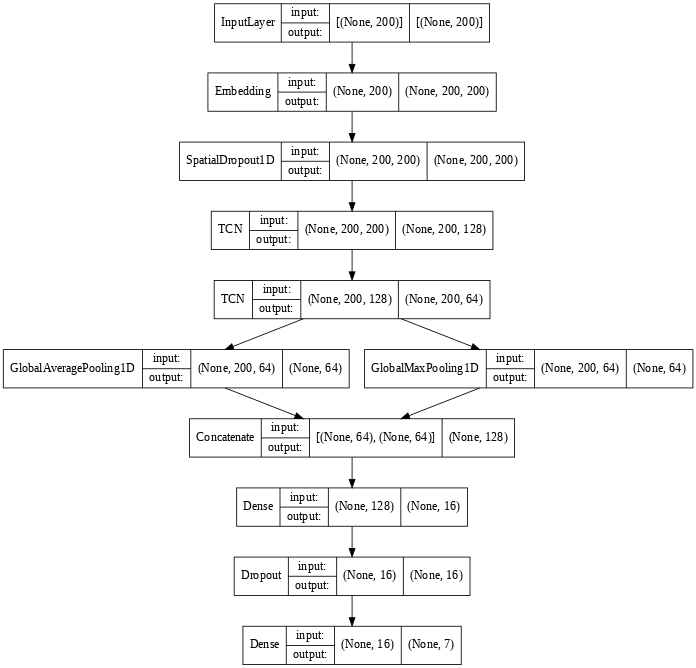

In [87]:
plot_model(second_model, show_shapes=True, show_layer_names=False, dpi=60)

## Training

The callbacks are the same of the first model.

The value of epochs is 40 and the value of batch size is equal to 128.

The values of parameters have been tuned during some experiments.

In [88]:
early2 = EarlyStopping(monitor = "val_f1_score", 
                         mode = "max", 
                         min_delta = 0, 
                         patience=7, 
                         verbose = 2,
                         restore_best_weights = True)

mc2 = ModelCheckpoint('./tcn.h5', 
                      monitor = 'val_f1_score', 
                      mode = 'max', 
                      verbose = 1, 
                      save_best_only = True)

In [89]:
history = second_model.fit(x_train_vec, y_train_enc,
                    epochs = 40, batch_size = 128,
                    validation_data = (x_val_vec,y_val_enc),
                    verbose = 1,
                    callbacks = [mc2, early2])

Epoch 1/40
340/340 [==============================] - ETA: 0s - loss: 1.4025 - f1_score: 0.2218
Epoch 1: val_f1_score improved from -inf to 0.25123, saving model to ./tcn.h5
340/340 [==============================] - 22s 55ms/step - loss: 1.4025 - f1_score: 0.2218 - val_loss: 1.2073 - val_f1_score: 0.2512
Epoch 2/40
340/340 [==============================] - ETA: 0s - loss: 1.1552 - f1_score: 0.3407
Epoch 2: val_f1_score improved from 0.25123 to 0.39193, saving model to ./tcn.h5
340/340 [==============================] - 17s 50ms/step - loss: 1.1552 - f1_score: 0.3407 - val_loss: 1.0468 - val_f1_score: 0.3919
Epoch 3/40
340/340 [==============================] - ETA: 0s - loss: 1.0409 - f1_score: 0.3992
Epoch 3: val_f1_score improved from 0.39193 to 0.41528, saving model to ./tcn.h5
340/340 [==============================] - 17s 49ms/step - loss: 1.0409 - f1_score: 0.3992 - val_loss: 0.9885 - val_f1_score: 0.4153
Epoch 4/40
340/340 [==============================] - ETA: 0s - loss: 0.9

In [90]:
y_pred = np.argmax(second_model.predict(x_test_vec), axis = 1)
y_true = np.argmax(y_test_enc, axis = 1)

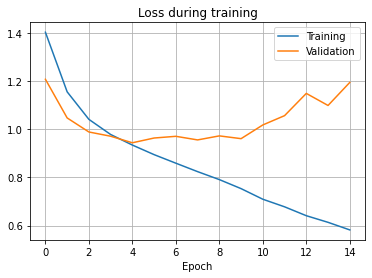

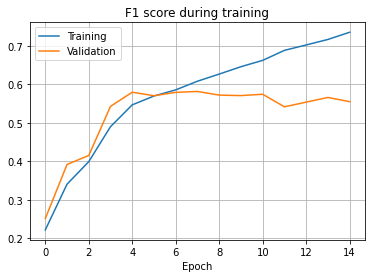

In [91]:
display_history(history)

In [92]:
print(classification_report(y_true, y_pred))
print("F1-score: " + str(f1_score(y_true, y_pred, average = 'macro')))

              precision    recall  f1-score   support

           0       0.46      0.46      0.46       572
           1       0.52      0.37      0.43       116
           2       0.64      0.63      0.63        81
           3       0.74      0.81      0.77      1978
           4       0.61      0.58      0.59      1648
           5       0.56      0.53      0.54       355
           6       0.59      0.54      0.56       677

    accuracy                           0.64      5427
   macro avg       0.59      0.56      0.57      5427
weighted avg       0.63      0.64      0.64      5427

F1-score: 0.5716650297736295


As you can see the model starts to overfit after the 13th epoch, hence the weights of the 13th epoch have been restored.

The model reached a **F1-score** of **0.57**.

# Conclusion

The best model for the F1-score metric is the **first model** for better score, since it reaches a **F1-score** of **0.61** with about 7M parameters to train.

$^1$Polignano, Marco & Basile, Pierpaolo & de Gemmis, Marco & Semeraro, Giovanni. (2019). "A Comparison of Word-Embeddings in Emotion Detection from Text using BiLSTM, CNN and Self-Attention". \\
https://www.researchgate.net/publication/333740389_A_Comparison_of_Word-Embeddings_in_Emotion_Detection_from_Text_using_BiLSTM_CNN_and_Self-Attention

$^2$S. bai, J. Kolter, and V. Koltun, "An empirical Evaluation of Generic Convolutional and Recurrent Networks for Sequence Modelling", *arXiv*, April, 2018

$^3$C. Henkel, "Temporal Convolutional Network", *Kaggle*,
https://www.kaggle.com/code/christofhenkel/temporal-convolutional-network/notebook